In [1]:
%matplotlib inline
import pandas as pd
from glob import glob
import sys
import json
import os
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from autoexperiment.template import generate_job_defs
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

def get_samples_per_sec(path):
    all_vals = []
    data = open(path).readlines()
    for line in data:
        if "Train Epoch" in line:
            vals = re.findall("\d+\.\d*\/s,", line)
            vals = [float(v.replace("/s,", "")) for v in vals]
            all_vals.extend(vals)
    return np.mean(all_vals[1:])

In [2]:
model_profile = pd.read_csv("https://raw.githubusercontent.com/mlfoundations/open_clip/main/docs/model_profile.csv")
model_profile  = model_profile.set_index("model")

In [58]:
path = "config_const_lr.yaml"

if path == "config_cosine_lr.yaml":
    jobs = generate_job_defs("config_cosine_lr.yaml")
    train_jobs = [job for job in jobs if job.params['mode'] == 'train']
    #train_jobs = [job for job in train_jobs if job.params['phase'] == 'pretrain']
    results = []
    for job in train_jobs:
        folder = os.path.dirname(job.output_file)
        paths = glob(os.path.join(folder, "checkpoints", "*.json"))
        samples_per_sec = get_samples_per_sec(job.output_file) if os.path.exists(job.output_file) else None
        for path in paths:
            data = json.load(open(path))
            dic = {
                'model': job.params['model'],
                "pretrain_dataset": job.params['dataset'],
                "downstream_dataset": data['dataset'],
                'epoch': int(re.search(r"epoch\_([0-9]+).pt", path).groups(1)[0]),
                "total_epochs": int(job.params["epochs"]),
                "name": job.params["name"],
                "gflops_total": model_profile.loc[job.params["model"]].gflops * int(job.params["epochs"]) * job.params["train_num_samples"],
                "samples_per_sec": samples_per_sec,
                "samples_per_sec_per_gpu": samples_per_sec / (job.params["nodes"] * 4),
                "global_batch_size": job.params["batch_size"] * job.params["nodes"] * 4,
                "training_time_hours": ((1/samples_per_sec) * int(job.params["epochs"]) * job.params["train_num_samples"]) / 3600,
                "gpus": job.params["nodes"] * 4,
                "total_steps": (int(job.params["epochs"]) * job.params["train_num_samples"]) // (job.params["batch_size"] * job.params["nodes"] * 4)
            }
            dic["gpu_hours"] = dic["gpus"] * dic["training_time_hours"]
            dic.update(job.params)
            dic.update(data['metrics'])
            results.append(dic)
    results = pd.DataFrame(results)
elif path  == "config_const_lr.yaml":
    jobs = generate_job_defs("config_const_lr.yaml")
    train_jobs = [job for job in jobs if job.params['mode'] == 'train']
    train_jobs = [job for job in train_jobs if job.params['phase'] == 'cooldown']
    results = []
    for job in train_jobs:
        folder = os.path.dirname(job.output_file)
        paths = glob(os.path.join(folder, "checkpoints", "*.json"))
        samples_per_sec = get_samples_per_sec(job.output_file) if os.path.exists(job.output_file) else None
        for path in paths:
            data = json.load(open(path))
            last_epoch = int(job.params["cooldown_checkpoint"]) + int(job.params["epochs_cooldown"])
            total_epochs =  int(job.params["epochs_cooldown"])
            dic = {
                'model': job.params['model'],
                "pretrain_dataset": job.params['dataset'],
                "downstream_dataset": data['dataset'],
                'epoch': int(re.search(r"epoch\_([0-9]+).pt", path).groups(1)[0]),
                "total_epochs": last_epoch,
                "name": job.params["name"],
                "gflops_total": model_profile.loc[job.params["model"]].gflops *total_epochs * job.params["train_num_samples"],
                "samples_per_sec": samples_per_sec,
                "samples_per_sec_per_gpu": samples_per_sec / (job.params["nodes"] * 4),
                "global_batch_size": job.params["batch_size"] * job.params["nodes"] * 4,
                "training_time_hours": ((1/samples_per_sec) * total_epochs * job.params["train_num_samples"]) / 3600,
                "gpus": job.params["nodes"] * 4,
                "total_steps": ((total_epochs) * job.params["train_num_samples"]) // (job.params["batch_size"] * job.params["nodes"] * 4)
            }
            dic["gpu_hours"] = dic["gpus"] * dic["training_time_hours"]
            dic.update(job.params)
            dic.update(data['metrics'])
            results.append(dic)
    results = pd.DataFrame(results)

/p/project/ccstdl/laion/mamba/envs/experimental-torch-nightly/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/p/project/ccstdl/laion/mamba/envs/experimental-torch-nightly/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


# Results

In [59]:
cols = [
    'model', 'samples_seen_scale', 'downstream_dataset', 
    "lr", "gflops_total", "siglip", "gpus", "batch_size", "global_batch_size", "samples_per_sec", 
    "training_time_hours", "total_steps", "name"
]

In [60]:
d = results[results.total_epochs==results.epoch]
ds = 'wds/imagenet1k'
metric = 'acc1'
d = d[d.downstream_dataset==ds]
d[[metric] + cols].sort_values(by=metric, ascending=False).round(4)

,acc1,model,samples_seen_scale,downstream_dataset,lr,gflops_total,siglip,gpus,batch_size,global_batch_size,samples_per_sec,training_time_hours,total_steps,name
23,0.6872,ViT-B-32,12.8B,wds/imagenet1k,0.001,4.729600e+10,False,256,354,90624,213746.2742,4.1586,35310,datacomp_ViT-B-32_ep100_lr0.001_b1_0.9_b2_0.95_wd0.2_w500_gc1_n64_bs354_sigFalse_cooldown12.8B_train
9,0.6453,ViT-B-32,3B,wds/imagenet1k,0.001,9.459200e+09,False,256,354,90624,NaN,NaN,7062,datacomp_ViT-B-32_ep100_lr0.001_b1_0.9_b2_0.95_wd0.2_w500_gc1_n64_bs354_sigFalse_cooldown3B_train
3,0.5974,ViT-B-32,1.28B,wds/imagenet1k,0.001,3.783680e+09,False,256,354,90624,215189.6387,0.3305,2824,datacomp_ViT-B-32_ep100_lr0.001_b1_0.9_b2_0.95_wd0.2_w500_gc1_n64_bs354_sigFalse_cooldown1.28B_train


<Axes: >

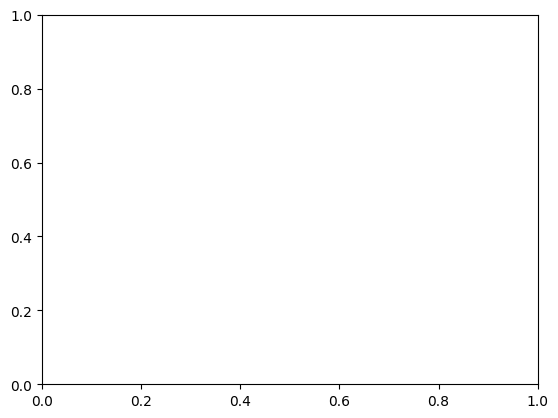

In [47]:
d = results[results.total_epochs==results.epoch].copy()
ds = 'wds/imagenet1k'
metric = 'acc1'
d = d[d.downstream_dataset==ds]
d = d[d.samples_seen_scale=="1.28M"]
sns.barplot(x="global_batch_size", y="acc1", hue="lr", data=d, estimator="max", errorbar=None)

<Axes: >

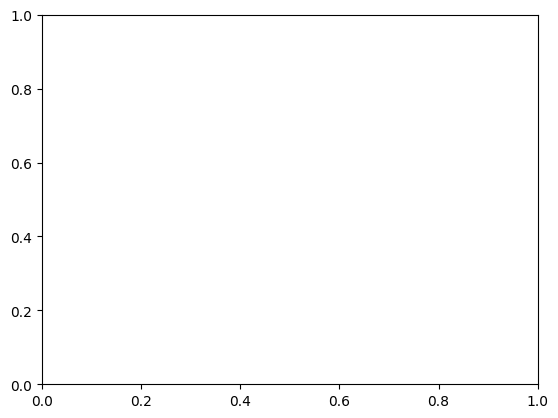

In [48]:
d = results[results.total_epochs==results.epoch].copy()
ds = 'wds/imagenet1k'
metric = 'acc1'
d = d[d.downstream_dataset==ds]
d = d[d.samples_seen_scale=="1.28M"]
sns.barplot(x="global_batch_size", y="acc1", hue="siglip", data=d, estimator="max", errorbar=None)

In [49]:
d = results[results.total_epochs==results.epoch].copy()
ds = 'wds/imagenet1k'
metric = 'acc1'
d = d[d.downstream_dataset==ds]
d = d[d.samples_seen_scale=="1.28M"]
#d = d[d.samples_seen_scale=="128M"]
d["name"] = d["name"].apply(lambda n:n.replace("sigTrue", "").replace("sigFalse", ""))
d = d.pivot(index="name", columns="siglip", values="acc1")
d = d.style.highlight_max(color='lightgreen', axis=1)
d

name


In [50]:
d = results[results.total_epochs==results.epoch]

ds = 'wds/mscoco_captions'
metric = 'image_retrieval_recall@5'

d = d[d.downstream_dataset==ds]
d[[metric] + cols].sort_values(by=metric, ascending=False).round(4)

,image_retrieval_recall@5,model,samples_seen_scale,downstream_dataset,lr,gflops_total,siglip,gpus,batch_size,global_batch_size,samples_per_sec,training_time_hours,total_steps,name
43,0.6135,ViT-B-32,12.8B,wds/mscoco_captions,0.001,4.729600e+10,False,256,354,90624,213746.2742,4.1586,35310,datacomp_ViT-B-32_ep100_lr0.001_b1_0.9_b2_0.95_wd0.2_w500_gc1_n64_bs354_sigFalse_cooldown12.8B_train
5,0.5768,ViT-B-32,3B,wds/mscoco_captions,0.001,9.459200e+09,False,256,354,90624,NaN,NaN,7062,datacomp_ViT-B-32_ep100_lr0.001_b1_0.9_b2_0.95_wd0.2_w500_gc1_n64_bs354_sigFalse_cooldown3B_train
1,0.5306,ViT-B-32,1.28B,wds/mscoco_captions,0.001,3.783680e+09,False,256,354,90624,215189.6387,0.3305,2824,datacomp_ViT-B-32_ep100_lr0.001_b1_0.9_b2_0.95_wd0.2_w500_gc1_n64_bs354_sigFalse_cooldown1.28B_train


# Downstream Task Learning curves

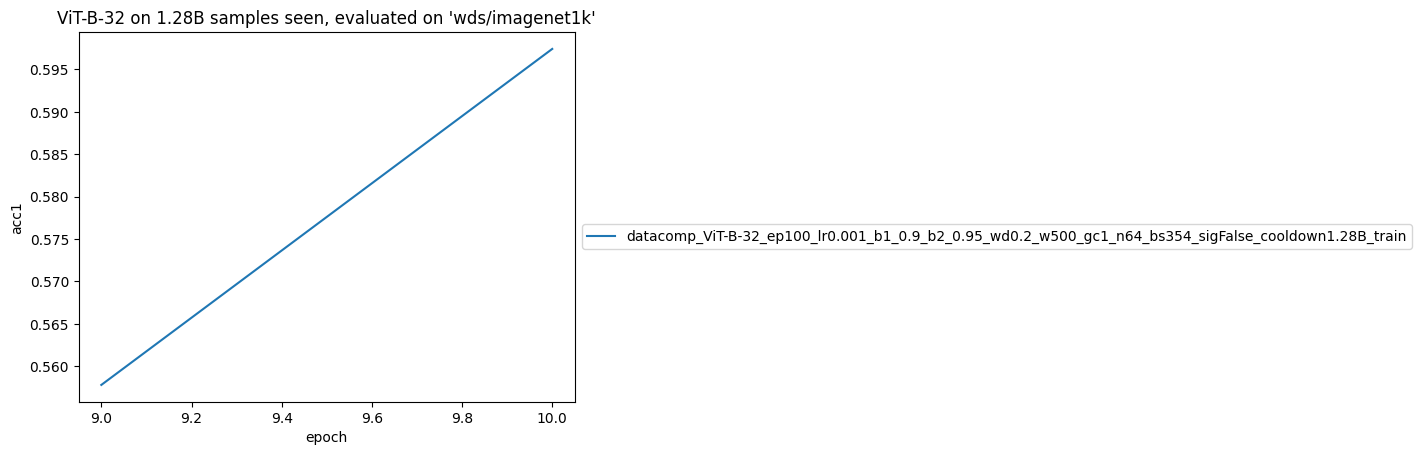

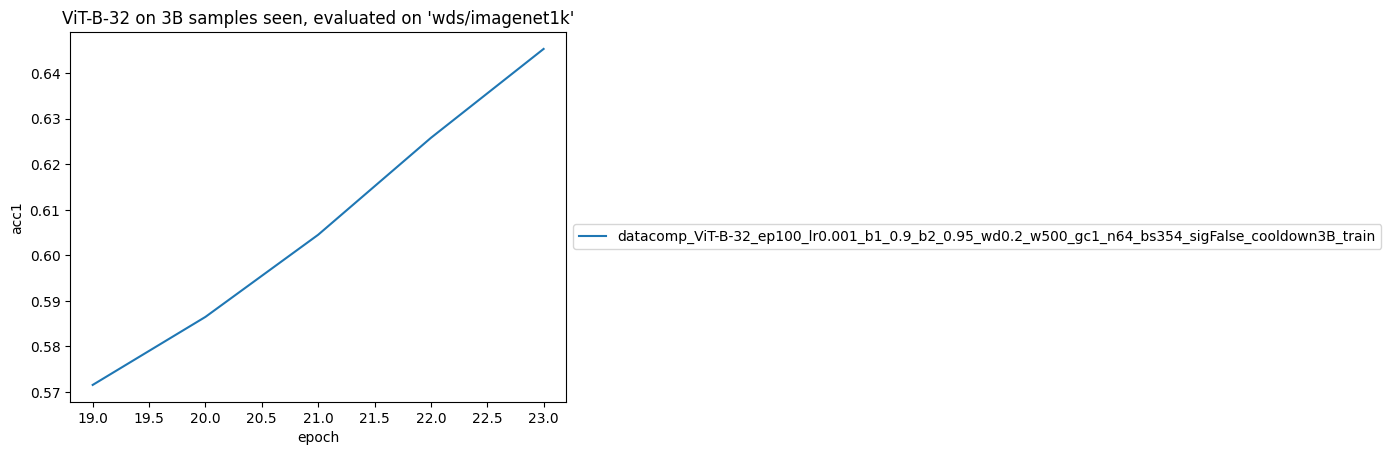

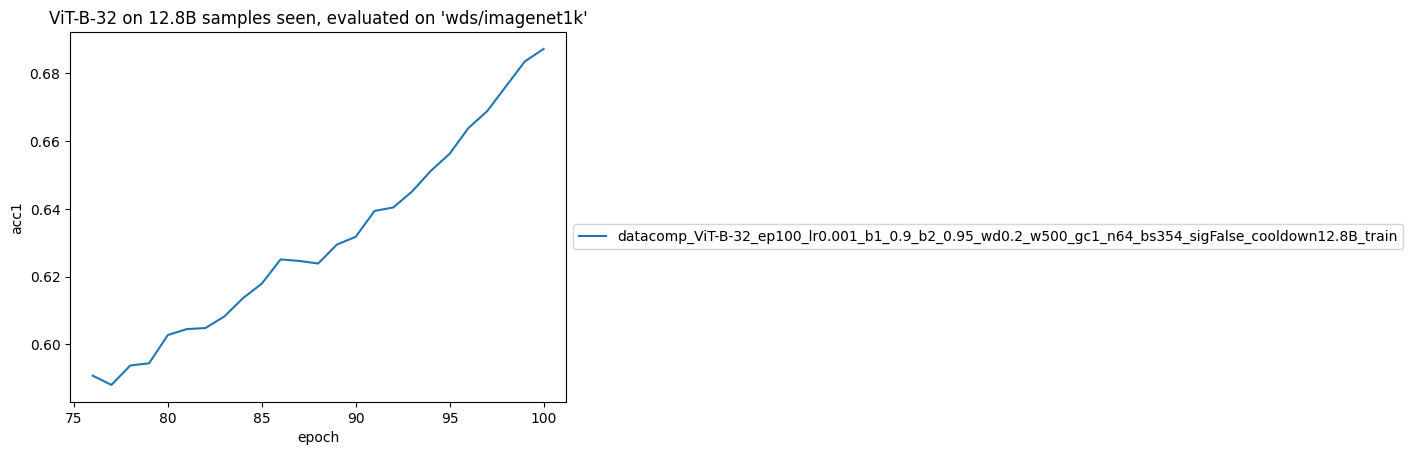

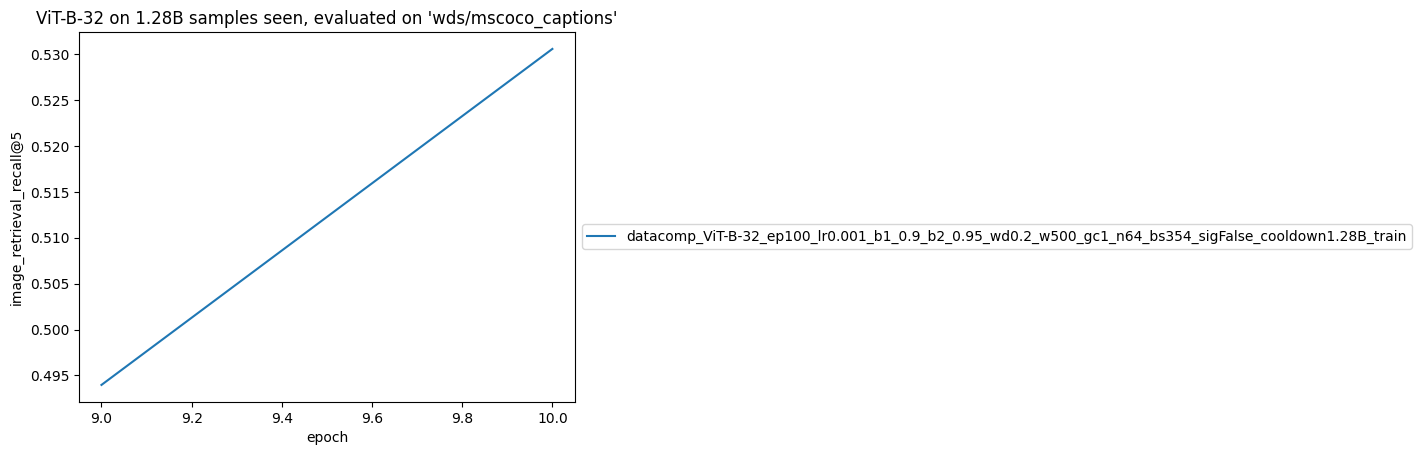

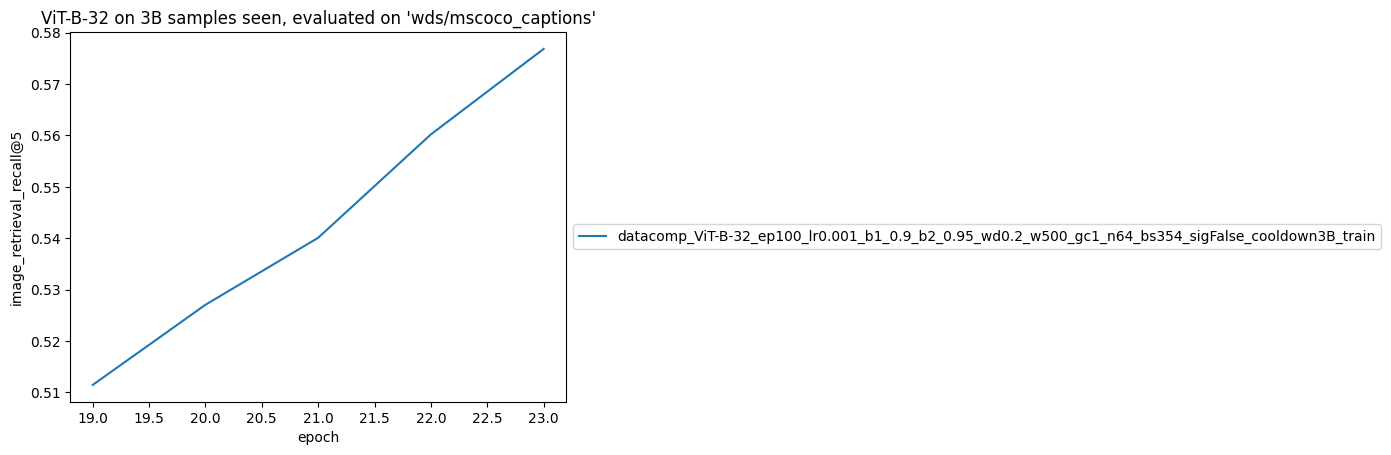

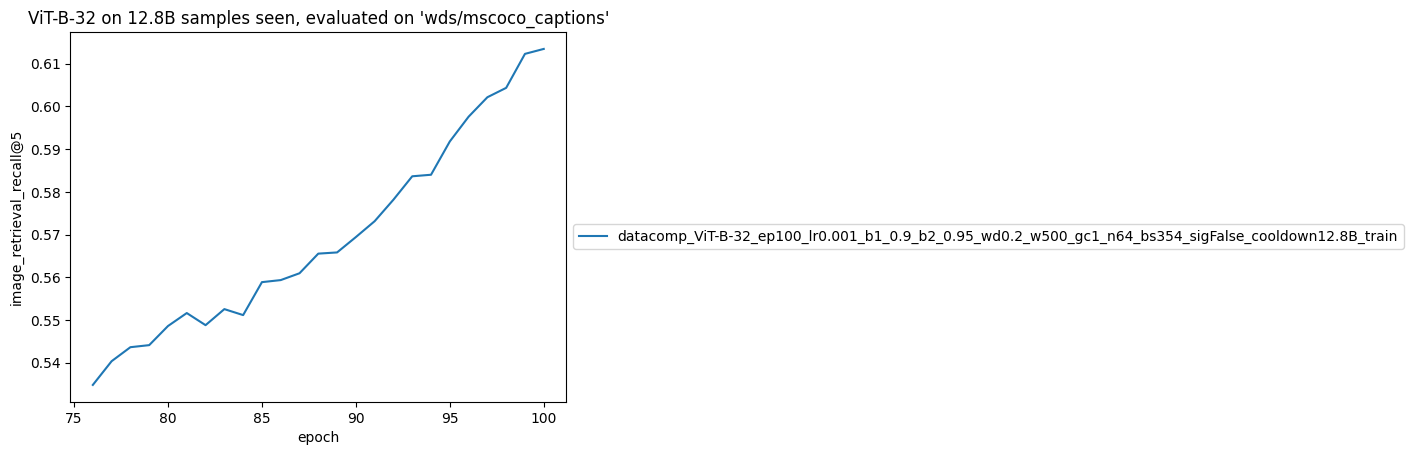

In [51]:
for model in ("ViT-B-32",):
    for (ds, metric) in ( ("wds/imagenet1k", "acc1"), ("wds/mscoco_captions", "image_retrieval_recall@5")):
        for samples_seen in ("1.28M", "128M", "1.28B", "3B", "12.8B"):
            d = results
            d = d[(d.model == model) & (d.samples_seen_scale==samples_seen) & (d.downstream_dataset==ds)]
            if not len(d):
                continue
            sns.lineplot(x="epoch", y=metric, data=d, hue="name")
            #d = d.sort_values(by='epoch')
            #d.plot(x='epoch', y=metric)
            plt.title(f"{model} on {samples_seen} samples seen, evaluated on '{ds}'")
            plt.legend(bbox_to_anchor=(1,0.5))
            plt.show()

# Scaling curve

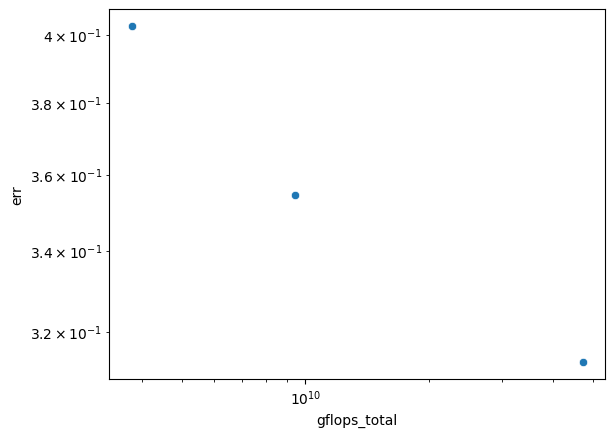

In [52]:
d = results[results.total_epochs==results.epoch]
ds = 'wds/imagenet1k'
metric = 'acc1'
d = d[d.downstream_dataset==ds]
d["err"] = 1 - d[metric]
sns.scatterplot(x="gflops_total", y="err", data=d)
plt.xscale("log")
plt.yscale("log")